# AIS Pipelines Tutorial

In this workshop you will learn how to design, deploy and run Australian Imaging Service pipelines in your local environment, and submit them to be included in the community repository.

##### Run a dynamic version of this notebook
1. Prerequisites
1. Set up your Git/GitHub
1. Clone pipelines-community repository
1. Launch notebook

##### Prepare test environment

1. Personalise environment variables
1. Explore the community pipelines repository
1. Start up a test XNAT instance to test the pipelines

##### Build and deploy your first pipelines

1. Build *Zip* pipeline from an existing example specification
1. Install, enable and launch the zip pipeline using the XNAT UI
1. Build *FSL BET* pipeline image
1. Install, enable and launch the BET pipeline using `pydra2app ext xnat (install|launch)-command`s

##### Design a pipeline to run mri_synthstrip
1. Create a new Git branch
1. Generate specification for *mri_synthstrip* command
1. Build *mri_synthstrip* pipeline
1. Install project-specific Freesurfer license
1. Test the *mri_synthstrip* pipeline
1. Create a test pull-request on GitHub

##### Design a pipeline to run mri_convert

* Using methods used for `mri_synthstrip` design a pipeline to run Freesurfer's `mri_convert`

##### Design your own pipeline (if you have one in mind)

* Design, build and test your own pipeline using the methods demonstrated in previous sections


## Run a dynamic version of this notebook (skip to next section if you already are)

If you are viewing this notebook @ https://nbviewer.org and you want to execute the cells, you will need to clone this repository run a version of this notebook locally

#### Prerequisites

Your system will need to have the following software installed

* Bash terminal (available on all macOS or Linux, maybe try Cygwin if on Windows noting this [fix for Docker](https://stackoverflow.com/questions/42560379/docker-commands-fail-in-cygwin-docker-service-is-up))
* Git
* Python3 (>=3.8)
* Docker runtime <=24.* (with non-root priveliges, i.e. doesn't require sudo, see [here](https://docs.docker.com/engine/install/linux-postinstall/))

NB: At the time of writing Docker runtime <=v24.* is required to run XNAT's container service (CS) in the test XNAT because the CS needs to be adapted to work with the latest Docker engine versions. Hopefully this issue is resolved soon to allow you to use the latest Docker version. If you are using Docker Desktop, the latest version with the engine <24.* is Docker Desktop v4.26.0, which can be downloaded [here](https://docs.docker.com/desktop/release-notes/)

#### Set up your Git/GitHub

Fork your own copy of the community pipelines repository

1. Navigate to https://github.com
1. Create a GitHub user account (if you don't have one already)
1. Generate a private/public SSH key using `ssh-keygen` in a Bash terminal (if you don't have one already)
1. Add your public the SSH key (`~/.ssh/id_rsa.pub` by default) to your GitHub account under `Settings>SSH and GPG keys` (if it isn't already)
1. Fork the https://github.com/Australian-Imaging-Service/pipelines-community into your GitHub user account

#### Clone pipelines-community repository

First make a directory in which to store your repository, typically this is just called `git` and is in your home directory

In [ ]:
mkdir -p ~/git

Next clone your local fork of the pipelines community, replacing <span style="color:orange">"your-github-username"</span> with your GitHub username. If it doesn't work please review the *Set up your Git/GitHub* section above and make sure you have followed all the steps correctly

In [ ]:
git clone git@github.com:"your-github-username"/pipelines-community ~/git/pipelines-community

#### Launch notebook

It is a good idea to install the Python depedencies for this tutorial in a separate "virtual environment" to keep it separate from the rest of your environment. We will install it inside the repository here.

In [ ]:
python3 -m venv ~/git/pipelines-community/pipelines-tutorial.venv


Activate the virtual environment you just created. This step needs to be done every time you relaunch the tutorial notebook

In [ ]:
source ~/git/pipelines-community/pipelines-tutorial.venv/bin/activate

Verify that your environment has been activated properly by ensuring the active Python version is the one installed at `~/git/pipelines-community/pipelines-tutorial.venv/bin/python`

In [ ]:
which python

Install the Python requirements of this notebook and the pipeline build-chain in general

In [ ]:
pip install -r ~/git/pipelines-community/tutorial/requirements.txt
python -m bash_kernel.install

Launch a dynamic version of this notebook

In [ ]:
jupyter notebook ~/git/pipelines-community/tutorial/ais-pipelines-tutorial.ipynb

Now you should be ready to go, close this tab and use the live notebook that should have just opened up :)

## Prepare test environment

#### Personalise environment variables

Change the following environment variables to appropriate values for you

In [ ]:
export INSTITUTION_NAME="name-of-your-institution-goes-here"  # e.g. "sydney" for The University of Sydney (assumes domain is *.edu.au)
export GROUP_NAME="name-of-your-group-goes-here"  # e.g. "sydneyimaging" for Sydney Imaging
export AUTHORS_NAME="Your name goes here"
export AUTHORS_EMAIL="your.email@goes.here"
export GITHUB_USER="your-github-username"
export PATH_TO_LOCAL_REPO="$HOME/git/pipelines-community"  # whereever you have installed the repository containing this notebook

Configure your local Git user in a bash terminal (if you haven't already)

In [ ]:
git config --global user.name "${AUTHORS_NAME}"
git config --global user.email ${AUTHORS_EMAIL}

#### Explore the community pipelines repository

Change to the repository directory containing this tutorial

In [ ]:
cd ${PATH_TO_LOCAL_REPO}

Examine the structure of the pipelines repository using the `tree` utility

In [ ]:
tree . --gitignore

Examine the layout of the *Zip* pipelines specification

In [ ]:
cat specs/australian-imaging-service-community/examples/zip.yaml

#### Start up a test XNAT instance to test the pipelines

Start a test XNAT on your machine/VM using the `xnat4tests` package

In [ ]:
xnat4tests start

It will take XNAT a couple of minutes to boot up. Once the frame above completes successfully you will be able to navigate to http://localhost:8080 and login with username=`admin`, password=`admin`.

Now we will add some open-source data from OpenNeuro to our XNAT in order to test the pipelines we will build

In [ ]:
xnat4tests add-data simple-dir
xnat4tests add-data openneuro-t1w

## Build and deploy your first pipelines

#### Build *Zip* pipeline from an existing example specification

Checkout the help for the `pydra2app make` command we will use to build the pipeline from the specification

In [ ]:
pydra2app make --help

Run the `pydra2app make` command to build the Zip pipeline from its specification

Notes:

* The name of the built image is taken from its relative file-system path, so we pass the `--spec-root` option to specify where this path should start from
* The `--for-localhost` is required to be able to run the pipeline using the test XNAT repository, i.e. it is only used in development not production
* We export the generated `xnat_command.json` file from the build directory, so we can easily copy it into the XNAT UI in subsequent steps

In [ ]:
pydra2app make xnat \
./specs/australian-imaging-service-community/examples/zip.yaml \
--spec-root ./specs \
--for-localhost \
--export-file xnat_command.json ~/zip-xnat-command.json

**NOTES:**
* `--spec-root` the name and organisation given to the generated image is based on the file path to the specification file, the spec root specifies where this path should be relative to (if not provided it is the current working directory
* `--for-localhost` is required when running the containers on a test XNAT server installed on the localhost
* `--export-file` exports generated files from the build directory to a location they can be accessed more conveniently

We can take a look at the *XNAT command JSON* that is generated by the make process. This is the specification that
tells XNAT how to run the pipeline within the image

In [ ]:
cat ~/zip-xnat-command.json

### Install, enable and launch the zip pipeline using the XNAT UI

##### Install the pipeline
1. Navigate to http://localhost:8080
1. Login with default XNAT credentials: username=`admin` password=`admin`
1. Click on the `Administer` menu item in top ribbon and select `Plugin Settings` from the drop-down menu
1. Select `Images & Commands` under the `Container Service` heading from the left-hand menu
1. Click the `New Command` button and copy and paste the command JSON generated by the build process in the dialog that opens (replacing the `{}` that is already there) and click `Save Command`

##### Enable the pipeline globally
1. Select `Command Configurations` item from the left-hand menu under `Container Service`
1. Toggle the `Enabled` switch next to the Zip pipeline

NB: This enables the pipeline globally, but users still cannot launch the pipeline at this stage. It still needs to be enabled for each project it is to be run on by a project owner.

##### Enable the pipeline for a specific project
1. Navigate back to the home screen by clicking the XNAT logo in the top-left corner
1. Select the `SIMPLE_DIR` project
1. Select `Project Settings` from the bottom of the right-hand actions menu
1. Select `Configure Commands` from the left-hand menu
1. Toggle the `Enabled` switch next to the Zip pipeline

##### Launch the pipeline
1. Navigate back to project home by clicking the `SIMPLE_DIR` breadcrumb
1. Select either one of the two subjects
1. Select the MR session
1. Click on the `Run containers` from the bottom of the right-hand side actions menu and select "Zip up a file or directory"
1. In the `To_zip` field of the dialog that opens up enter `a-directory` to select the scan that is to be zipped and click `Run Container`

##### Check the status of the pipeline
1. In the `History` panel click the `Reload` button and you should see the pipeline status
1. Select the "eye" image that appears to the right of the status when you hover over it to view details of the workflow status
1. If the workflow has failed (after a successful launch), you can view the output and error logs by clicking the `View StdOut.log` and `View StdErr.log` buttons at the bottom of the page.
1. (Advanced) to access the working directory of the command in order to debug anything that has gone wrong, look up the `container-host-path` of the `work` mount listed under `container mounts` (see image below)
1. Select `Manage Files` from the right-hand side Actions menu to view the generated zip file

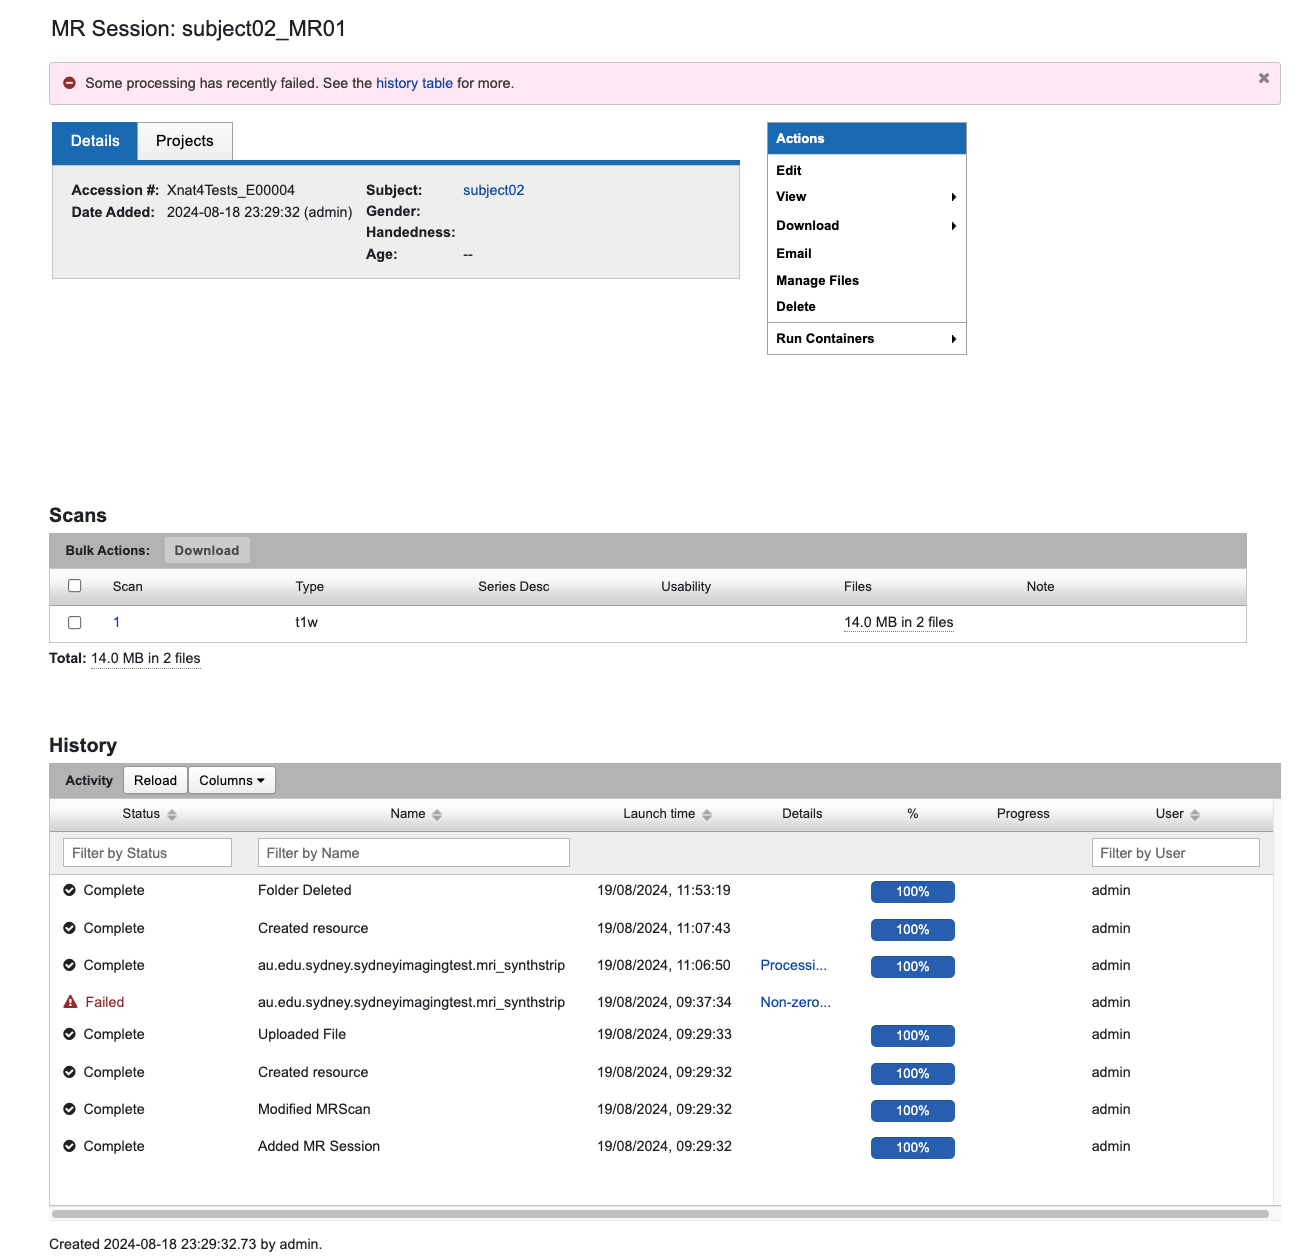

The above screenshot demonstrates what both a successful and failed pipeline will look like in the *History* table. Successful pipelines will show up as *Complete* in black and failed pipelines as *Failed* in red.

For convenience (primarily during testing), I have created a couple of commands to install and launch pipelines via the CLI

Save an access token for the local test XNAT

In [ ]:
pydra2app ext xnat save-token \
--server http://localhost:8080 \
--user admin \
--password admin

Install and enable the build pipeline

In [ ]:
pydra2app ext xnat install-command \
australian-imaging-service-community/examples.zip:3.0 \
--enable \
--enable-project SIMPLE_DIR \
--replace-existing

Launch the installed pipeline

In [ ]:
pydra2app ext xnat launch-command \
examples.zip \
SIMPLE_DIR \
subject01_1 \
--input to_zip a-directory

#### Build FSL BET pipeline image

Build the example BET specification this time including the licence you just downloaded into the image (as this is permitted by the licence conditions)

In [ ]:
pydra2app make xnat \
./specs/australian-imaging-service-community/examples/bet.yaml \
--spec-root ./specs \
--for-localhost

Launch the BET pipeline using the command line tools

In [ ]:
pydra2app ext xnat install-command \
australian-imaging-service-community/examples.bet:6.0.6.4-1 \
--enable \
--enable-project OPENNEURO_T1W \
--replace-existing

In [ ]:
pydra2app ext xnat launch-command \
examples.bet \
OPENNEURO_T1W \
subject02_MR01 \
--input t1w t1w

## Design a pipeline to run mri_synthstrip

In this next section we will generate a specification to build a pipeline for the `mri_synthstrip` brain extraction tool from scratch using the `pydra2app bootstrap` command and then build and test it using the same methods as above

<span style="color:orange">**NOTE:**</span> You may need access to a GPU to run mri_synthstrip effectively

#### Create a new Git branch

So we are able to add the pipeline we generate to the Australian Imaging Service Community repository (and get it deployed automatically) we first create a new Git branch to hold our changes

In [ ]:
git checkout -b mri-synthstrip

#### Generate specification for *mri_synthstrip* command

Using the `pydra2app bootstrap` command we can generate a YAML specification for mri_synthstrip

In [ ]:
pydra2app bootstrap --help

Run the `pydra2app bootstrap` command to automatically generate a YAML specification, which we can edit later

In [ ]:
pydra2app bootstrap \
./specs/australian-imaging-service-community/au/edu/${INSTITUTION_NAME}/${GROUP_NAME}/mri_synthstrip.yaml \
--author "${AUTHORS_NAME}" ${AUTHORS_EMAIL} \
--version 1.6 \
--title "MRI Synthstrip" \
--base-image name freesurfer/synthstrip \
--base-image tag 1.6 \
--base-image package_manager apt \
--base-image python python3 \
--packages-system python3-pip \
--command-task common:shell \
--command-input head "datatype=medimage/nifti-gz,configuration.position=-2,configuration.argstr=-i" \
--command-output mri_synthstrip_brain "datatype=medimage/nifti-gz,configuration.position=-1,configuration.argstr=-o" \
--command-configuration executable mri_synthstrip \
--docs-url https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/ \
--description 'SynthStrip is a skull-stripping tool that extracts brain voxels from a landscape of image types, ranging across imaging modalities, resolutions, and subject populations. It leverages a deep learning strategy to synthesize arbitrary training images from segmentation maps, yielding a robust model agnostic to acquisition specifics.'

cat ./specs/australian-imaging-service-community/au/edu/${INSTITUTION_NAME}/${GROUP_NAME}/mri_synthstrip.yaml

echo ""
echo "You can now manually edit the yaml file at './specs/australian-image-service-community/au/edu/${INSTITUTION_NAME}/${GROUP_NAME}/mri_convert.yaml'"

#### Build the `mri_synthstrip` pipeline

Build the newly created pipeline specification

In [ ]:
pydra2app make xnat \
./specs/australian-imaging-service-community/au/edu/${INSTITUTION_NAME}/${GROUP_NAME}/mri_synthstrip.yaml \
--spec-root ./specs \
--for-localhost

#### Test the new pipeline

Install and launch your newly created pipeline

In [ ]:
pydra2app ext xnat install-command \
australian-imaging-service-community/au.edu.${INSTITUTION_NAME}.${GROUP_NAME}.mri_synthstrip:1.6-1 \
--enable \
--enable-project OPENNEURO_T1W \
--replace-existing

In [ ]:
pydra2app ext xnat launch-command \
au.edu.${INSTITUTION_NAME}.${GROUP_NAME}.mri_synthstrip \
OPENNEURO_T1W \
subject02_MR01 \
--input head t1w

#### Create a test pull-request on GitHub

Commit your changes and push them to your GitHub fork

In [ ]:
git commit -am"added specification for Freesurfer's mri_synthstrip"
git push -u origin mri-synthstrip

Once you are happy with the performance of your pipeline (if not earlier), create a pull-request on GitHub from your fork:

1. Navigate to your fork of the AIS community pipelines repo, https://github.com/\${GITHUB_USER}/pipelines-community
1. Select "Pull requests" in the top ribbon
1. Click the "New pull request" button
1. Select "base:main" <- "${GITHUB_USER}:mri-convert" from the drop-down lists
1. Click "Create pull request"

#### Acceptance of pipeline into community repository

A pull-request will then trigger the process for the pipeline to be accepted and deployed onto AIS:

1. Maintainers of AIS Community Pipelines repository will be notified that you wish to add your pipeline to the community repository.
1. The repository maintainers (RM) will review your proposed pipeline for security issues
1. RM will potentially request some changes to your specification
1. RM accept your pipeline and merge your pull request
1. The pipeline is built using the continuous integration and deployment actions running on GitHub
1. Your local AIS node automatically checks for newly pipelines and the latest version is pulled to the node


## Design a pipeline to run `mri_convert`

#### Bootstrap the `mri_convert` specification

Using the same procedure as used for `mri_synthstrip` bootstrap a specification file for `mri_convert` at `australian-imaging-service-community/au.edu.$INSTITUTION_NAME.$GROUP_NAME.mri_convert:7.4.1-1`

You will need to change the following options/sections at a minimum

  * Change the `--title`, `--docs-url` and `--description` options/YAML-sections to appropriate values, and `--version 7.4.1`
  * Change the base image options to:
    * `--base-image name vnmd/freesurfer_7.4.1`
    * `--base-image tag 20231214`
    * `--base-image package_manager yum` (Fedora based image)
    * Drop the `--base-image python python3` option
      * NB we can use Conda Python installed by default because the `mri_convert` command isn't a Python script that requires specific pacakges already installed
  * Change the command options to:
    * Change `--command-configuration` to be `mri_convert`
    * Change the `--command-(input|output)` options/YAML-sections to match the CLI of the `mri_convert` tool, see https://surfer.nmr.mgh.harvard.edu/fswiki/mri_convert for reference.
      * `configuration.position` is the 0-indexed position on the command line that the input|output is expected (negative numbers are indexed from the end as they are in Python, i.e. -1 specifies the last position, -2 the second-last, etc...).
      * `configuration.argstr` is the flag prefix to be prepended to the argument on the command line, e.g. `-i` -> `-i /path/to/a/file.nii`. Use the empty string `''` if no prefix is required. If you need to place characters around the argument you can use Python string formatting syntax, e.g. for a input called myinput `-i[{myinput}]` -> `-i[/path/to/a/file.nii]` on the command line
    * Add as many parameters to the command as you see fit to implement various mri_convert functionalities, e.g. `--command-parameter cutends 'datatype=field/integer,configuration.argstr=--cutends'`
  * Drop the `--packages-system python3-pip` option as we will use Conda Python instead
  * Include a licence hook for the freesurfer license with a nickname for the license, where it will be installed in the container, URL from which to acquire the licence and a description of why the license is required, `--license freesurfer /opt/freesurfer/license.txt https://surfer.nmr.mgh.harvard.edu/registration.html 'Required license to run any commands in the Freesurfer package'`


#### Install a project-specific Freesurfer licence using FrameTree

To run a pipeline with a dynamic license (i.e. not provided at build-time by the `--license option`, you need to upload the license to the project you want to run the pipeline against. This enables licences with strict requirements to associated with specific users.

To start off with please request a Freesufer license to upload from the [Freesurfer site](https://surfer.nmr.mgh.harvard.edu/registration.html). Next we will use the *Frametree* package that *pydra2app* uses under the hood to upload the license you have acquired into the project we want to run the pipeline on.

First step is to store the credentials used to login to the XNAT instance, which we will give the nickname `test-xnat` in this example

In [ ]:
frametree store add xnat test-xnat --server http://localhost:8080 --user admin --password admin

The next step is to define a "FrameTree Dataset" within the project we want to run the pipeline on, i.e. the `OPENNEURO_T1W` project.

In [ ]:
frametree dataset define test-xnat//OPENNEURO_T1W

Now we are able to install the freesurfer license into this dataset we have defined

In [ ]:
frametree dataset install-license freesurfer ~/freesurfer-license.txt test-xnat//OPENNEURO_T1W

#### Build, install, launch and debug the generated pipeline

Like the previous sections we use `pydra2app make xnat` to make the Dockerized pipeline from the specification we have generated

In [ ]:
pydra2app make xnat \
./specs/australian-imaging-service-community/au/edu/${INSTITUTION_NAME}/${GROUP_NAME}/mri_convert.yaml \
--spec-root ./specs \
--for-localhost

Install using `install-command`

In [ ]:
pydra2app ext xnat install-command \
australian-imaging-service-community/au.edu.${INSTITUTION_NAME}.${GROUP_NAME}.mri_convert:7.4.1-1 \
--enable \
--enable-project OPENNEURO_T1W \
--replace-existing

Launch using `launch-command`

In [ ]:
pydra2app ext xnat launch-command \
au.edu.${INSTITUTION_NAME}.${GROUP_NAME}.mri_convert \
OPENNEURO_T1W \
subject01_MR01 \
--input <the-name-you-gave-to-the-input-in-your-yaml> t1w

## Design your own pipeline
1. Create and switch to a new Git branch (you will notice that your mri-convert changes will disappear)

In [ ]:
git checkout main
git checkout -b my-own-pipeline

2. Bootstrap your new specification
1. Build your specifcation
1. Test your specification
1. Create a pull-request on GitHub to add your pipeline to the central repository, https://github.com/Australian-Imaging-Service/pipelines-community